In [1]:
import json, sys, math
from IPython.display import Image, display
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages')

In [2]:
#!pip3 install bazinBlackBody
#import bazinBlackBody
#help(bazinBlackBody)

### Fitting a 2D surface 
The axes are wavelength (microns) and time (days). 
The functions are exponential in time (linear in magnitude) times blackbody; 
and Bazin in time (exp rise then exp fall) times blackbody.

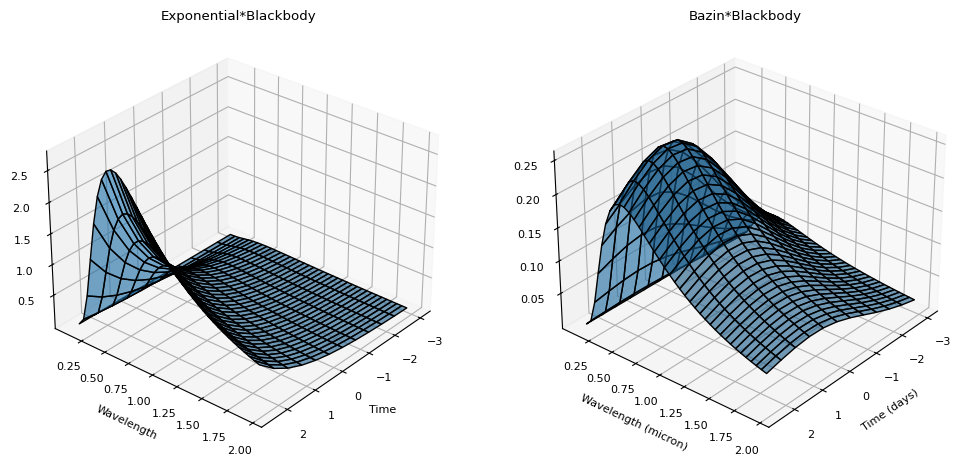

In [10]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

T = 5   # Just choose arbitrary temperature 5,000 Kelvin
def blackbody(wl, T):
    hck = 14.387
    q = np.exp(hck/(wl*T))
    return np.power(wl, -3.0) /(q - 1)
def bazinBB(tau, wl):
    T = 10
    kr = 1
    kf = 0.3
    ef = np.exp(-kf*tau)
    er = np.exp(-kr*tau)
    return blackbody(wl, T) * ef/(1+er)
def expBB(tau, wl):
    T = 10
    k = 0.7
    er = np.exp(k*tau)
    return blackbody(wl, T) * er

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.azim = ax2.azim = 40
tau = np.arange(-3, 3, 0.5)
wl  = np.arange(0.1, 2.0, 0.05)
Tau, Wl = np.meshgrid(tau, wl)

zs = np.array(expBB(np.ravel(Tau), np.ravel(Wl)))
Z = zs.reshape(Tau.shape)
ax1.plot_surface(Tau, Wl, Z, edgecolors='k', alpha=.6)
ax1.set_xlabel('Time')
ax1.set_ylabel('Wavelength')
ax1.set_title('Exponential*Blackbody')

zs = np.array(bazinBB(np.ravel(Tau), np.ravel(Wl)))
Z = zs.reshape(Tau.shape)
ax2.plot_surface(Tau, Wl, Z, edgecolors='k', alpha=.6)
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Wavelength (micron)')
ax2.set_title('Bazin*Blackbody')

plt.show()

### Fitting a lightcurve
To run this code, you need `pip install BazinBlackBody`

In [4]:
# Here is a fake alert
file = 'SNIbc_312228'
alert = json.loads(open('json/%s.json'%file).read())

discoveryMJD = alert['diaSourcesList'][0]['midpointMjdTai']
print(discoveryMJD)

59582.3282


The return from the fitting is a pair. It tries to fit both ExpBB and BazinBB. Each dictionary carries 
the fitting paramters, and also `Rsq`, the remaining variance after the fit, compared to the variance about the mean.
The fit with lowest `Rsq` is the best one.

In [5]:
from bazinBlackBody import BBBEngine
BE = BBBEngine.BBB('LSST', nforced=4, ebv=0, A=100, T=4, t0=6, kr=0.1, kf=0.01, verbose=True)
(dicte, dictb) =  BE.make_fit(alert)

12345678 has 57
Bazin: T=3.75 (g-r=0.913), kr=0.127, kf=0.013


In [6]:
if dicte:
    print('Rsq fit is %.4f' % dicte['Rsq'])
    filename = 'image/%s_e.png'%file
    BE.plot(alert, dicte, filename)
    display(Image(filename=filename))

{'npoint': 57, 'Rsq': 0.031039655128024195, 'A': 7339.160331778965, 'T': 3.7513994380811897, 't0': 32.24365957517049, 'kr': 0.12725382601931892, 'kf': 0.01299183533511458, 'Aerr': 1556.458511510024, 'Terr': 0.1307007391788284, 't0err': 3.6829685214731454, 'krerr': 0.01617251076568898, 'kferr': 0.004383345442786961, 'peakTime': 49.32898372260745, 'peakValue': 116.51895058147075, 'post_discovery': 87.68089999999938, 'mjd_discovery': 59582.3282, 'tns_name': ''}
Rsq fit is 0.0310


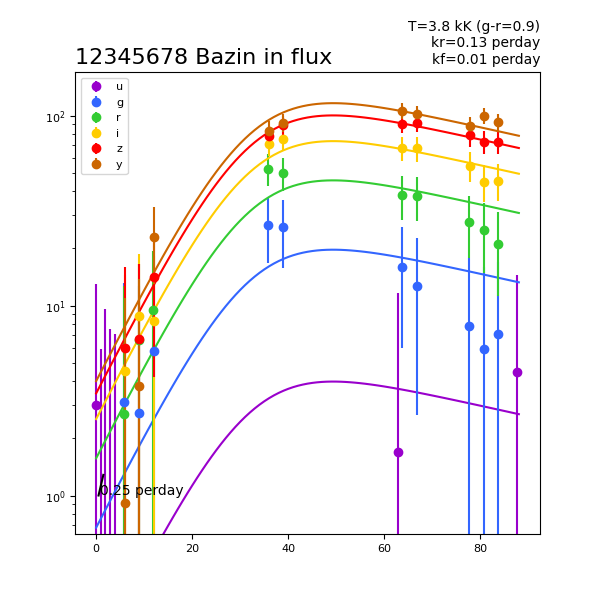

In [7]:
if dictb:
    print(dictb)
    print('Rsq fit is %.4f' % dictb['Rsq'])
    filename = 'image/%s_b.png'%file
    BE.plot(alert, dictb, filename)
    display(Image(filename=filename))

In [8]:
if dicte and dictb:
    if dicte['Rsq'] < dictb['Rsq']:
        print('Best fit is Exponential*BlackBody')
    else:
        print('Best fit is Bazin*BlackBody')